Nama: Agus Heryanto
NIM: 22.11.4661

In [9]:
# Install required libraries
!pip install pandas numpy matplotlib seaborn missingno scikit-learn imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from google.colab import files
import io
import warnings
from scipy import stats
import re
import sys
from imblearn.pipeline import Pipeline
from datetime import datetime

warnings.filterwarnings('ignore')

# # Set style yang benar untuk visualisasi
# plt.style.use('default')  # atau 'classic'
# sns.set_theme()  # Menggunakan default seaborn theme

# # Set options pandas
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.width', 1000)

print("All libraries imported successfully!")

# Fungsi untuk mengecek instalasi
def check_installations():
    libraries = {
        'pandas': pd,
        'numpy': np,
        'matplotlib': plt,
        'seaborn': sns,
        'missingno': msno,
        'sklearn': SimpleImputer,
        'imblearn': SMOTE
    }

    print("Checking installations...")
    for lib_name, lib in libraries.items():
        if lib:
            print(f"✓ {lib_name} successfully imported")
        else:
            print(f"✗ {lib_name} import failed")

# Run check
check_installations()

All libraries imported successfully!
Checking installations...
✓ pandas successfully imported
✓ numpy successfully imported
✓ matplotlib successfully imported
✓ seaborn successfully imported
✓ missingno successfully imported
✓ sklearn successfully imported
✓ imblearn successfully imported


In [10]:
# Load dataset
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(
#         name=fn, length=len(uploaded[fn])))
# df = pd.read_csv(io.BytesIO(uploaded[fn]))

url = "https://raw.githubusercontent.com/agusheryanto182/job-recommendations/refs/heads/develop/scraper-service/linkedin_jobs_20250407_020136.csv"
df = pd.read_csv(url)

1. DATA DESCRIPTION

a. Dimensi Dataset:
Jumlah baris: 1182
Jumlah kolom: 15

b. Tipe Data Setiap Kolom:
job_id                int64
title                object
company              object
location_city        object
location_province    object
location_country     object
seniority_level      object
employment_level     object
job_function         object
industries           object
posted_date          object
description          object
keywords             object
link                 object
num_applicants       object
dtype: object

c. Statistik Deskriptif:
             job_id
count  1.182000e+03
mean   4.170715e+09
std    6.039651e+07
min    3.318539e+09
25%    4.175061e+09
50%    4.189546e+09
75%    4.195254e+09
max    4.202307e+09

d. Sample Data (5 baris pertama):
       job_id                          title  \
0  4199554439       Internship Web Developer   
1  4188450252            Front End Developer   
2  4178221580                  Web Developer   
3  4158977188               

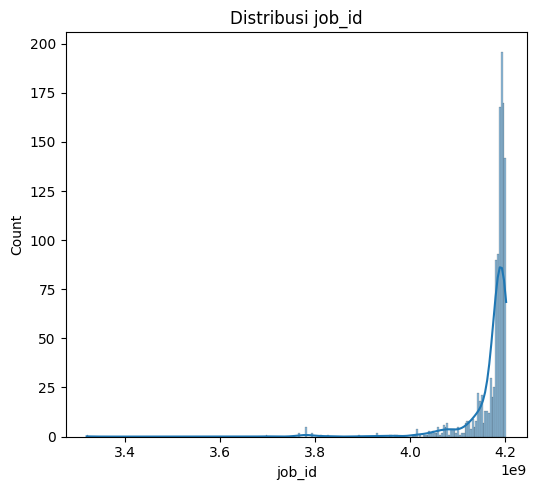


c. Box Plot untuk Deteksi Outlier


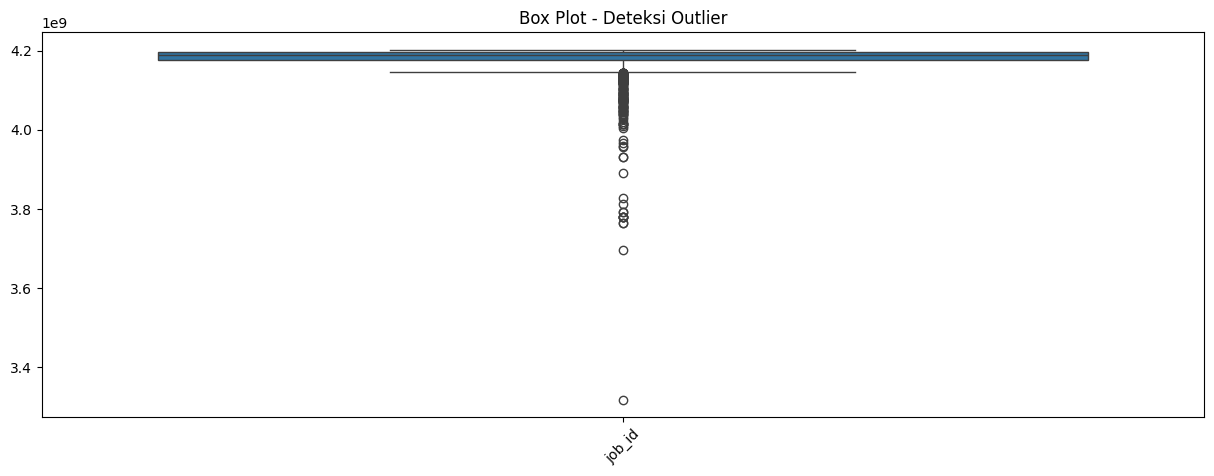


d. Analisis Missing Values:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

3. DATA QUALITY ASSESSMENT

a. Kelengkapan Data:
Persentase kelengkapan setiap kolom:
job_id               100.0
title                100.0
company              100.0
location_city        100.0
location_province    100.0
location_country     100.0
seniority_level      100.0
employment_level     100.0
job_function         100.0
industries           100.0
posted_date          100.0
description          100.0
keywords             100.0
link                 100.0
num_applicants       100.0
dtype: float64

b. Analisis Duplikasi:
Jumlah baris duplikat: 0

c. Pemeriksaan Akurasi Data:

Range nilai untuk kolom numerik:
            job_id
min   3.318539e+09
max   4.202307e+09
mean  4.170715e+09
std   6.039651e+07

d. Analisis Keunikan:
job_id: 1182 nilai unik
title: 866 nilai unik
company: 706 nilai unik
location_city: 256 nilai unik
location_province: 22 nilai unik
location_country: 3 nilai unik
senio

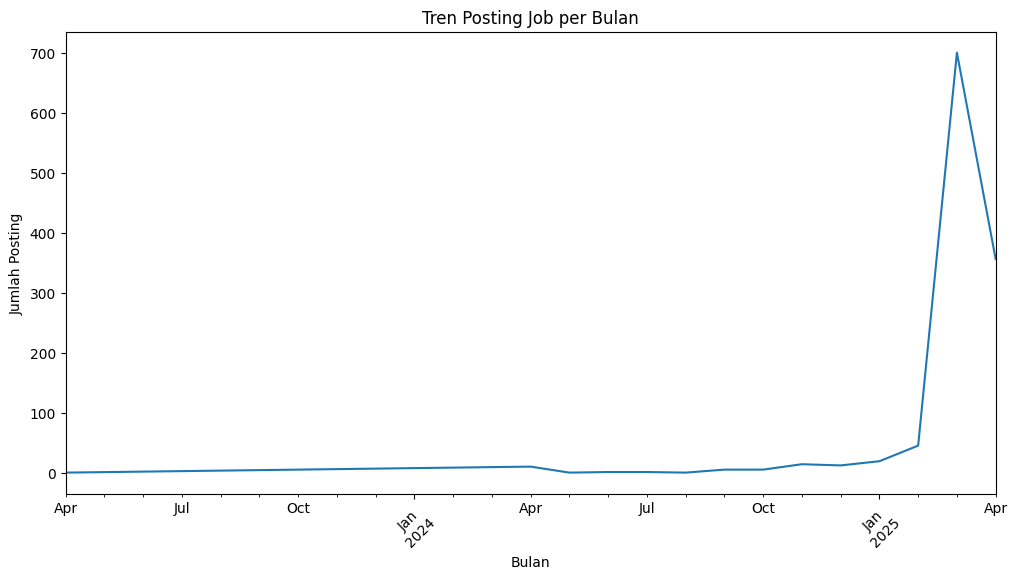


Top 10 Keywords:
development: 783
support: 759
service: 691
lead: 660
design: 614
communication: 602
product: 594
systems: 476
intern: 461
git: 436


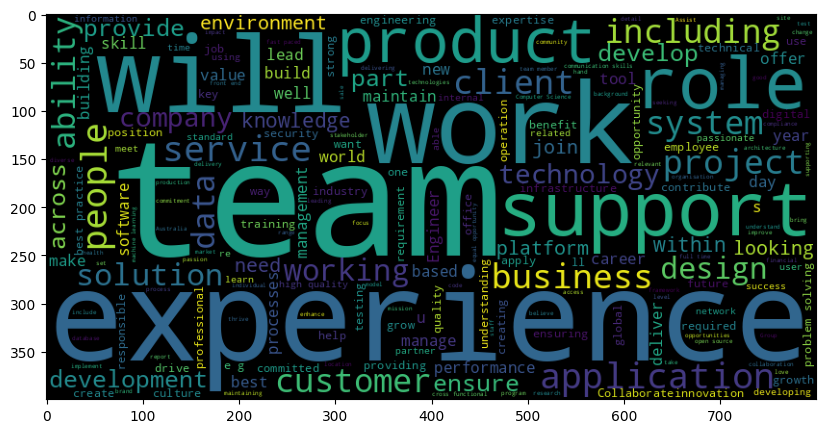

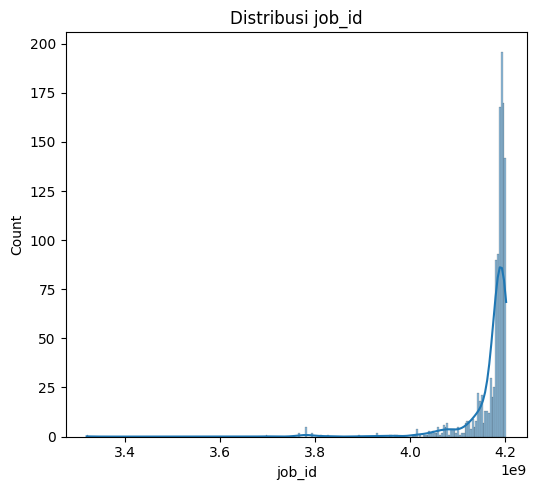

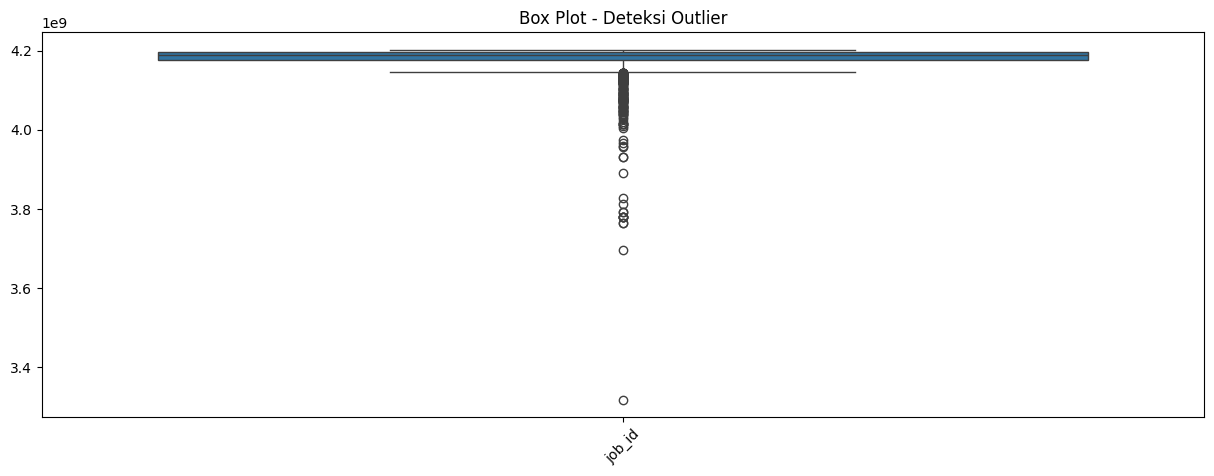

Laporan telah disimpan ke data_analysis_report.txt


In [11]:
def clean_text(text):
    # Using regular expression to remove newline characters
    # and ensure text is a string (handles NaN as well)
    return re.sub(r'\n', ' ', str(text))

def comprehensive_data_analysis(df):
    """
    Fungsi untuk melakukan analisis komprehensif dataset
    """

    # Cleaning the categorical columns that might be used for labels
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(clean_text)

    # 1. DATA DESCRIPTION
    print("="*50)
    print("1. DATA DESCRIPTION")
    print("="*50)

    # a. Jumlah observasi dan fitur
    print("\na. Dimensi Dataset:")
    print(f"Jumlah baris: {df.shape[0]}")
    print(f"Jumlah kolom: {df.shape[1]}")

    # b. Tipe data setiap kolom
    print("\nb. Tipe Data Setiap Kolom:")
    print(df.dtypes)

    # c. Statistik deskriptif
    print("\nc. Statistik Deskriptif:")
    print(df.describe())

    # d. Sampel data
    print("\nd. Sample Data (5 baris pertama):")
    print(df.head())

    # 2. DATA EXPLORATION
    print("\n" + "="*50)
    print("2. DATA EXPLORATION")
    print("="*50)

    # a. Visualisasi distribusi untuk kolom numerik
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    if len(numeric_cols) > 0:
        print("\na. Visualisasi Distribusi Kolom Numerik")
        plt.figure(figsize=(15, 5*((len(numeric_cols)-1)//3 + 1)))
        for i, col in enumerate(numeric_cols, 1):
            plt.subplot((len(numeric_cols)-1)//3 + 1, 3, i)
            sns.histplot(df[col], kde=True)
            plt.title(f'Distribusi {col}')
        plt.tight_layout()
        plt.show()

    # b. Korelasi antar variabel numerik
    if len(numeric_cols) > 1:
        print("\nb. Heatmap Korelasi")
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
        plt.title('Correlation Heatmap')
        plt.show()

    # c. Box Plot untuk deteksi outlier
    if len(numeric_cols) > 0:
        print("\nc. Box Plot untuk Deteksi Outlier")
        plt.figure(figsize=(15, 5))
        sns.boxplot(data=df[numeric_cols])
        plt.xticks(rotation=45)
        plt.title('Box Plot - Deteksi Outlier')
        plt.show()

    # d. Analisis Missing Values
    print("\nd. Analisis Missing Values:")
    missing_values = df.isnull().sum()
    missing_percentages = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentages
    })
    print(missing_df[missing_df['Missing Values'] > 0])

    # 3. DATA QUALITY ASSESSMENT
    print("\n" + "="*50)
    print("3. DATA QUALITY ASSESSMENT")
    print("="*50)

    # a. Kelengkapan Data
    print("\na. Kelengkapan Data:")
    completeness = (1 - df.isnull().sum() / len(df)) * 100
    print("Persentase kelengkapan setiap kolom:")
    print(completeness)

    # b. Konsistensi Data (Duplikasi)
    print("\nb. Analisis Duplikasi:")
    duplicates = df.duplicated().sum()
    print(f"Jumlah baris duplikat: {duplicates}")

    # c. Akurasi Data (Basic checks)
    print("\nc. Pemeriksaan Akurasi Data:")
    numeric_summary = df[numeric_cols].agg(['min', 'max', 'mean', 'std'])
    print("\nRange nilai untuk kolom numerik:")
    print(numeric_summary)

    # d. Analisis Keunikan
    print("\nd. Analisis Keunikan:")
    for column in df.columns:
        unique_count = df[column].nunique()
        print(f"{column}: {unique_count} nilai unik")

    return None

# Fungsi untuk menghasilkan laporan dalam format yang bisa disimpan
def generate_analysis_report(df, output_file="data_analysis_report.txt"):
    """
    Menghasilkan laporan analisis dan menyimpannya ke file
    """

    # Redirect output ke string buffer
    old_stdout = sys.stdout
    result = io.StringIO()
    sys.stdout = result

    # Jalankan analisis
    comprehensive_data_analysis(df)

    # Restore stdout dan dapatkan string output
    sys.stdout = old_stdout

    # Simpan ke file
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(result.getvalue())

    print(f"Laporan telah disimpan ke {output_file}")

# Analisis Kategorikal yang Lebih Detail
def analyze_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        print(f"\nAnalisis kolom {col}:")
        print(df[col].value_counts().head())
        print(f"Total kategori unik: {df[col].nunique()}")

        # # Visualisasi
        # plt.figure(figsize=(10, 5))
        # df[col].value_counts().plot(kind='bar')
        # plt.title(f'Distribusi {col}')

        # # Replace newline characters in x-axis tick labels
        # plt.xticks(rotation=45, ha='right')  # Adjust horizontal alignment
        # labels = [label.get_text().replace('\n', ' ') for label in plt.gca().get_xticklabels()]
        # plt.gca().set_xticklabels(labels)

        # plt.show()

# Analisis Temporal (untuk kolom posted_date)
def analyze_temporal_data(df):
    df['posted_date'] = pd.to_datetime(df['posted_date'])

    print("\nAnalisis Temporal:")
    print("Range tanggal:", df['posted_date'].min(), "sampai", df['posted_date'].max())

    # Tren posting per bulan
    monthly_posts = df['posted_date'].dt.to_period('M').value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    monthly_posts.plot(kind='line')
    plt.title('Tren Posting Job per Bulan')
    plt.xlabel('Bulan')
    plt.ylabel('Jumlah Posting')
    plt.xticks(rotation=45)
    plt.show()

# Analisis Text untuk Description dan Keywords
from collections import Counter
import re

def analyze_text_data(df):
    # Analisis keywords
    all_keywords = []
    for keywords in df['keywords'].str.split('|'):
        if isinstance(keywords, list):
            all_keywords.extend(keywords)

    keyword_freq = Counter(all_keywords)

    print("\nTop 10 Keywords:")
    for keyword, count in keyword_freq.most_common(10):
        print(f"{keyword}: {count}")

    # Word cloud untuk description
    from wordcloud import WordCloud

    text = ' '.join(df['description'])
    wordcloud = WordCloud(width=800, height=400).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.axis


# 2. Jalankan analisis
comprehensive_data_analysis(df)

analyze_categorical_columns(df)

analyze_temporal_data(df)

analyze_text_data(df)

# 3. Generate dan simpan laporan
generate_analysis_report(df)

In [12]:
# Function to convert applicant numbers to numeric values
def convert_applicants_to_numeric(value):
    """
    Mengkonversi jumlah pelamar ke bilangan bulat
    Returns: int (bilangan bulat) atau np.nan
    """
    if pd.isna(value):
        return 0  # Ubah np.nan menjadi 0

    value = str(value).lower().strip()

    try:
        if 'over 200' in value:
            return 200
        elif 'be among the first' in value:
            try:
                return int(value.split()[4])
            except:
                return 0
        else:
            # Ekstrak angka dari string
            numbers = ''.join(filter(str.isdigit, value))
            return int(numbers) if numbers else 0
    except:
        return 0  # Return 0 jika ada error

# Function to safely handle keywords
def clean_keywords(value):
    if pd.isna(value):
        return ''
    if isinstance(value, list):
        return '|'.join(map(str, value))
    if isinstance(value, str):
        cleaned = value.replace('[', '').replace(']', '').replace("'", "")
        return cleaned
    return str(value)

# Missing Value Analysis
def analyze_missing_values(df):
    """
    Analisis missing value dengan penanganan khusus untuk 'nan' string
    """
    total_rows = len(df)

    # Fungsi untuk mengecek missing value
    def check_missing(series):
        # Cek NaN/None
        null_mask = series.isnull()
        # Cek string kosong
        empty_mask = (series == '') | (series == ' ')
        # Cek string 'nan'
        nan_string_mask = (series.astype(str).str.lower() == 'nan')
        # Gabungkan semua kondisi
        return null_mask | empty_mask | nan_string_mask

    # Hitung missing values
    missing_values = df.apply(check_missing).sum()
    missing_percentage = (missing_values / total_rows) * 100

    # Buat DataFrame hasil
    missing_info = pd.DataFrame({
        'Missing Values': missing_values,
        'Missing Percentage': missing_percentage
    })

    # Print detail untuk setiap kolom
    print("\nDetail missing values per kolom:")
    for col in df.columns:
        empty_count = (df[col] == '').sum()
        null_count = df[col].isnull().sum()
        nan_string_count = (df[col].astype(str).str.lower() == 'nan').sum()
        total_missing = empty_count + null_count + nan_string_count

        if total_missing > 0:
            print(f"\n{col}:")
            if empty_count > 0:
                print(f"  - Empty strings: {empty_count}")
            if null_count > 0:
                print(f"  - Null values: {null_count}")
            if nan_string_count > 0:
                print(f"  - 'nan' strings: {nan_string_count}")
            print(f"  - Total missing: {total_missing}")
            print(f"  - Percentage: {(total_missing / total_rows) * 100:.2f}%")
            # Tampilkan beberapa contoh nilai
            print(f"  - Sample values: {df[col].head().tolist()}")

    return missing_info.sort_values('Missing Percentage', ascending=False)

# Enhanced Missing Value Imputation with multiple strategies
def impute_missing_values(df, strategy='simple'):
    """
    Enhanced imputation untuk semua jenis missing values
    """
    df_imputed = df.copy()

    # 1. Handle keywords - menggunakan title dari row yang sama
    def get_keywords_from_title(title):
        """Helper function untuk mengekstrak keywords dari title"""
        if pd.isna(title) or str(title).strip() == '' or str(title).lower() == 'nan':
            return ''
        # Bersihkan dan split title menjadi keywords
        words = str(title).lower().split()
        # Hilangkan kata-kata umum yang tidak relevan
        stop_words = {'and', 'or', 'the', 'in', 'at', 'of', 'for', 'to', 'with'}
        keywords = [word for word in words if word not in stop_words]
        return '|'.join(keywords)

    # Untuk setiap row, jika keywords kosong, gunakan title dari row yang sama
    df_imputed['keywords'] = df_imputed.apply(
        lambda row: get_keywords_from_title(row['title'])  # menggunakan title dari row yang sama
        if pd.isna(row['keywords']) or str(row['keywords']).strip() == '' or str(row['keywords']).lower() == 'nan'
        else clean_keywords(row['keywords']),
        axis=1
    )

    # 2. Convert num_applicants
    df_imputed['num_applicants'] = df_imputed['num_applicants'].apply(convert_applicants_to_numeric)

    # 3. Imputation berdasarkan strategy
    if strategy == 'simple':
        # Categorical columns
        categorical_columns = [
            'title', 'company', 'location_city', 'location_province',
            'location_country', 'seniority_level', 'employment_level',
            'job_function', 'industries'
        ]

        # Mode imputation untuk categorical
        for col in categorical_columns:
            # Handle semua jenis missing values
            mask = (df_imputed[col].isna()) | \
                   (df_imputed[col] == '') | \
                   (df_imputed[col].astype(str).str.lower() == 'nan')

            mode_value = df_imputed[~mask][col].mode()[0]
            df_imputed.loc[mask, col] = mode_value

        # Numeric columns
        numeric_columns = ['job_id', 'num_applicants']
        for col in numeric_columns:
            median_value = df_imputed[col].median()
            df_imputed[col] = df_imputed[col].fillna(median_value)

    elif strategy == 'knn':
        # Numeric features untuk KNN
        numeric_columns = ['job_id', 'num_applicants']

        # Pastikan data numerik valid untuk KNN
        for col in numeric_columns:
            df_imputed[col] = pd.to_numeric(df_imputed[col], errors='coerce')

        # KNN imputation
        knn_imputer = KNNImputer(n_neighbors=5)
        df_imputed[numeric_columns] = knn_imputer.fit_transform(df_imputed[numeric_columns])

        # Categorical columns
        categorical_columns = [
            'title', 'company', 'location_city', 'location_province',
            'location_country', 'seniority_level', 'employment_level',
            'job_function', 'industries'
        ]

        # Mode imputation untuk categorical
        for col in categorical_columns:
            # Handle semua jenis missing values
            mask = (df_imputed[col].isna()) | \
                   (df_imputed[col] == '') | \
                   (df_imputed[col].astype(str).str.lower() == 'nan')

            mode_value = df_imputed[~mask][col].mode()[0]
            df_imputed.loc[mask, col] = mode_value

    # 4. Handle date column
    df_imputed['posted_date'] = pd.to_datetime(df_imputed['posted_date'], errors='coerce')
    mean_date = df_imputed['posted_date'].mean()
    df_imputed['posted_date'] = df_imputed['posted_date'].fillna(mean_date)

    # 5. Handle text columns
    df_imputed['description'] = df_imputed['description'].apply(
        lambda x: '' if pd.isna(x) or str(x).strip() == '' or str(x).lower() == 'nan'
        else str(x)
    )

    # 6. Final check untuk keywords
    empty_keywords = df_imputed['keywords'].apply(
        lambda x: pd.isna(x) or str(x).strip() == '' or str(x).lower() == 'nan'
    )
    if empty_keywords.any():
        df_imputed.loc[empty_keywords, 'keywords'] = default_keywords

    # 7. Final verification untuk semua kolom
    for col in df_imputed.columns:
        # Check berbagai jenis missing values
        mask = (df_imputed[col].isna()) | \
               (df_imputed[col].astype(str) == '') | \
               (df_imputed[col].astype(str).str.lower() == 'nan')

        if mask.any():
            print(f"\nWarning: Masih ada missing values di kolom {col}")
            print(f"Jumlah: {mask.sum()}")
            print("Sample values:")
            print(df_imputed.loc[mask, col].head())

            # Auto-fix untuk missing values yang tersisa
            if col in categorical_columns:
                df_imputed.loc[mask, col] = df_imputed[~mask][col].mode()[0]
            elif col in numeric_columns:
                df_imputed.loc[mask, col] = df_imputed[~mask][col].median()
            elif col == 'keywords':
                df_imputed.loc[mask, col] = default_keywords
            elif col == 'description':
                df_imputed.loc[mask, col] = ''
            elif col == 'posted_date':
                df_imputed.loc[mask, col] = mean_date

    return df_imputed

# Class Imbalance Handling
def handle_class_imbalance(df, target_column='seniority_level', method='smote'):
    """
    Handle class imbalance for multi-class target dengan menjaga semua kolom
    """
    # Simpan semua kolom original
    original_columns = df.columns.tolist()

    # Prepare the data
    numeric_features = ['num_applicants']
    categorical_features = ['employment_level', 'job_function']

    # Buat copy dataframe untuk processing
    df_process = df.copy()

    # Encode categorical features
    le_dict = {}
    X = df_process[numeric_features].copy()

    for cat_col in categorical_features:
        le = LabelEncoder()
        X[cat_col] = le.fit_transform(df_process[cat_col].astype(str))
        le_dict[cat_col] = le

    # Encode target
    le_target = LabelEncoder()
    y = le_target.fit_transform(df_process[target_column].astype(str))

    # Calculate class distribution
    class_counts = Counter(y)
    max_class_count = max(class_counts.values())

    # Define sampling strategy
    sampling_strategy = {
        class_label: max_class_count
        for class_label in class_counts.keys()
        if class_counts[class_label] < max_class_count
    }

    # Apply SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)

    # Create balanced dataframe dengan semua kolom
    df_balanced = pd.DataFrame(X_balanced, columns=numeric_features)

    # Decode categorical features
    for cat_col in categorical_features:
        df_balanced[cat_col] = le_dict[cat_col].inverse_transform(X_balanced[cat_col].astype(int))

    # Tambahkan target column yang sudah dibalancing
    df_balanced[target_column] = le_target.inverse_transform(y_balanced)

    # Copy kolom lain dari dataframe original
    other_columns = [col for col in original_columns if col not in
                    (numeric_features + categorical_features + [target_column])]

    # Ulangi nilai dari kolom lain sesuai dengan jumlah baris yang dibalancing
    for col in other_columns:
        # Ambil nilai unik dari kolom original
        unique_values = df[col].dropna().unique()
        # Generate nilai untuk baris baru
        if len(unique_values) > 0:
            df_balanced[col] = np.random.choice(unique_values, size=len(df_balanced))
        else:
            df_balanced[col] = None

    # Pastikan urutan kolom sama dengan dataframe original
    df_balanced = df_balanced[original_columns]

    return df_balanced

# Analysis of class balance
def analyze_class_distribution(df, column):
    print(f"\nClass distribution for {column}:")
    distribution = df[column].value_counts(normalize=True)
    print(distribution)
    return distribution

# Preprocessing untuk membersihkan data
def clean_data(df):
    """
    Membersihkan data dengan mengganti 'nan' string menjadi numpy.nan
    """
    df_clean = df.copy()

    # Ganti string 'nan' dengan numpy.nan
    for column in df_clean.columns:
        mask = df_clean[column].astype(str).str.lower() == 'nan'
        df_clean.loc[mask, column] = np.nan

    return df_clean

# Main execution
if __name__ == "__main__":
    print("Loading and analyzing data...")

    # Tampilkan data original
    print("\nSample data original:")
    print(df.head())

    # Analisis missing value pada data original
    print("\nAnalisis missing value (data original):")
    original_analysis = analyze_missing_values(df)

    # Bersihkan data
    df_clean = clean_data(df)

    # Analisis missing value setelah cleaning
    print("\nAnalisis missing value (setelah cleaning):")
    clean_analysis = analyze_missing_values(df_clean)

    # Tampilkan perbandingan
    print("\nPerbandingan sebelum dan sesudah cleaning:")
    comparison = pd.DataFrame({
        'Original Missing': original_analysis['Missing Values'],
        'Cleaned Missing': clean_analysis['Missing Values']
    })
    print(comparison)

    # 3. Analyze initial class distribution
    print("\nInitial Class Distribution:")
    initial_distribution = analyze_class_distribution(df, 'seniority_level')

    # 4. Apply missing value imputation
    print("\nApplying Missing Value Imputation...")
    df_clean = impute_missing_values(df, strategy='knn')

    # 5. Verify missing values after imputation
    print("\nMissing Values After Imputation:")
    print(analyze_missing_values(df_clean))

    # 6. Handle class imbalance
    print("\nHandling Class Imbalance...")
    print("\nClass distribution before balancing:")
    print(df_clean['seniority_level'].value_counts())

    df_balanced = handle_class_imbalance(df_clean, method='smote')

    # 7. Analyze final class distribution
    print("\nClass distribution after balancing:")
    print(df_balanced['seniority_level'].value_counts())

    # 8. Save the processed dataset
    df_balanced.to_csv('balanced_job_data.csv', index=False)

    # 9. Print summary statistics
    print("\nData Processing Summary:")
    print(f"Original dataset shape: {df.shape}")
    print(f"After cleaning shape: {df_clean.shape}")
    print(f"After balancing shape: {df_balanced.shape}")

    # 10. Display sample of final dataset
    print("\nSample of processed data:")
    print(df_balanced.head())

    # 11. Download the result in the csv
    files.download('balanced_job_data.csv')

Loading and analyzing data...

Sample data original:
       job_id                          title  \
0  4199554439       Internship Web Developer   
1  4188450252            Front End Developer   
2  4178221580                  Web Developer   
3  4158977188                  Web Developer   
4  4170847328  Frontend Developer (React JS)   

                             company  location_city location_province  \
0                      PT. Sasa Inti        Jakarta           Jakarta   
1      PT Adicipta Inovasi Teknologi        Jakarta           Jakarta   
2  PT Bank Digital BCA (BCA Digital)  South Jakarta           Jakarta   
3         PT Astra International Tbk        Jakarta           Jakarta   
4           Padepokan Tujuh Sembilan        Bandung         West Java   

  location_country seniority_level employment_level  \
0        Indonesia      internship       internship   
1        Indonesia       associate        full-time   
2        Indonesia       associate        full-time   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>